6-fold cross-validation

In [1]:
from pathlib import Path
from typing import Callable, List, Optional, Tuple, Any

from src.utils import ColName, load_train, load_test, make_deepchem, get_out_dir

import matplotlib.pyplot as plt
import datetime
import shutil

import deepchem as dc
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
train, test = load_train(), load_test()


def double_split(tbl: pd.DataFrame, split_colname: str) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    split_indices = np.unique(tbl[split_colname])
    return [(tbl[tbl[split_colname] != i_split], tbl[tbl[split_colname] == i_split]) for i_split in split_indices]


def triple_split(split_colname: str) -> Tuple[List[Tuple[pd.DataFrame, pd.DataFrame]], pd.DataFrame]:
    split_indices = np.unique(train[split_colname])
    final_valid = train[train[split_colname] == split_indices[0]]
    other_train = train[train[split_colname] != split_indices[0]]
    crossval_splits = double_split(tbl=other_train, split_colname=split_colname)
    return crossval_splits, final_valid


splits_maxmin, final_valid_maxmin = triple_split(ColName.minmax_split)
splits_strat, final_valid_strat = triple_split(ColName.strat_6fold_split)

splits_maxmin_6fold = double_split(train, ColName.minmax_split)
splits_strat_6fold = double_split(train, ColName.strat_6fold_split)


def prep_data(feat: dc.feat.Featurizer,
              splits: List[Tuple[pd.DataFrame, pd.DataFrame]],
              final_valid: Optional[pd.DataFrame] = None) -> Tuple[List[Tuple[dc.data.NumpyDataset,
                                                                              dc.data.NumpyDataset]],
                                                                   Optional[dc.data.NumpyDataset]]:
    result = [(make_deepchem(split[0], feat), make_deepchem(split[1], feat)) for split in splits]
    return (result, make_deepchem(final_valid, feat)) if final_valid is not None else result, None


seed = 0
n_classifiers = len(splits_strat)
common_out_dir = get_out_dir() / f"predict_different_{datetime.date.today()}"
f1_metric = dc.metrics.Metric(dc.metrics.f1_score)
ptrue_colname = "pTrue"

In [3]:
%%time
tf.random.set_seed(seed)
np.random.seed(seed)

feat_convmol = dc.feat.ConvMolFeaturizer()
test_convmol = make_deepchem(test, feat_convmol)
splits_maxmin_6fold_convmol, _ = prep_data(feat_convmol, splits_maxmin_6fold)

Wall time: 1min


In [4]:
def plot(train_losses: List[float], train_f1: List[float], val_f1: List[float], out_filename: Path) -> None:
    n_epoch = len(train_losses)
    plt.figure()
    plt.subplot(211)
    plt.scatter(range(n_epoch), train_losses)
    plt.ylabel("train loss")
    plt.subplot(212)
    plt.scatter(range(n_epoch), train_f1, label="train")
    plt.scatter(range(n_epoch), val_f1, label="valid")
    plt.legend()
    plt.ylabel("F1 score")
    plt.savefig(out_filename)

def experiment(models: List[dc.models.Model], splits: List[Tuple[dc.data.Dataset, dc.data.Dataset]],
               test_dc: dc.data.Dataset, title: str, n_epoch: int, swap_train_val: bool) -> Any:
    model_parent_dir = models[0].model_dir.parent
    test_results = test.copy()
    start_time = datetime.datetime.now()

    try:
        for i_model, (train_i, valid_i) in enumerate(splits):
            if swap_train_val:
                valid_i, train_i = train_i, valid_i
            model = models[i_model]
            train_losses, train_f1_scores, valid_f1_scores = [], [], []

            for _ in range(n_epoch):
                train_losses.append(model.fit(train_i, nb_epoch=1))
                train_f1_scores.append(model.evaluate(train_i, metrics=[f1_metric], per_task_metrics=True)[1][f1_metric.name][0])
                valid_f1_scores.append(model.evaluate(valid_i, metrics=[f1_metric], per_task_metrics=True)[1][f1_metric.name][0])


            plot(train_losses=train_losses, train_f1=train_f1_scores, val_f1=valid_f1_scores,
                 out_filename=model_parent_dir / f"model{i_model}performance.png")

            results_colname = f"{ptrue_colname}{title}{i_model}"
            test_results[results_colname] = model.predict(test_dc)[:, 0, 1]  # TODO not for every model so, (?) use switch
    finally:
        test_results.to_csv(model_parent_dir / "test.csv")
        end_time = datetime.datetime.now()
        with open(model_parent_dir / "timing.txt", "w") as timing_file:
            timing_file.writelines([f"start training: {start_time}\n", f"end training: {end_time}\n"])
        shutil.make_archive(common_out_dir / f"{title}_backup", "zip", model_parent_dir)


def experiment_shorthand(make_model: Callable[[Path], dc.models.Model], experiment_name: str, test_dc: dc.data.Dataset,
                         splits: List[Tuple[dc.data.Dataset, dc.data.Dataset]], n_epoch: int, swap_train_val: bool) -> None:
    tf.random.set_seed(seed)
    np.random.seed(seed)
    title = f"{experiment_name}_epochs{n_epoch}_swapValid{swap_train_val}"
    models_dir = common_out_dir / title
    models = [make_model(models_dir / f"model{i_model}") for i_model in range(len(splits))]
    experiment(models=models, splits=splits, test_dc=test_dc, title=title, n_epoch=n_epoch, swap_train_val=swap_train_val)

In [6]:
common_out_dir.mkdir(exist_ok=True, parents=True)
np.save(common_out_dir / "splits_convmol", splits_maxmin_6fold_convmol)

# Training GraphConvModel

In [3]:
# restoring
splits_maxmin_6fold_convmol = np.load(common_out_dir / "splits_convmol.npy", allow_pickle=True)

feat_convmol = dc.feat.ConvMolFeaturizer()
test_convmol = make_deepchem(test, feat_convmol)

In [4]:
%%capture --no-display
train_extended = load_train(extended=True)
splits_ext_maxmin_6fold = double_split(train_extended, ColName.minmax_split)
n_tasks = 2

def transform_dataset(new_tbl: pd.DataFrame) -> dc.data.NumpyDataset:
    y_nc, y_cl = "n.nc", "n.cl"
    new_x = feat_convmol.featurize(new_tbl[ColName.smi])
    new_y = new_tbl[[ColName.active,
                     y_nc,
                     ]]
    new_y[y_nc] = (new_y[y_nc] != 0)
    return dc.data.NumpyDataset(X=new_x, y=np.array(new_y))


splits_ext_maxmin_6f_convmol = []
for (train_i, val_i) in splits_ext_maxmin_6fold:
    new_train_dc = transform_dataset(train_i)
    new_val_dc = transform_dataset(val_i)
    splits_ext_maxmin_6f_convmol.append((new_train_dc, new_val_dc))
test_convmol_ext = dc.data.NumpyDataset(X=test_convmol.X, n_tasks=n_tasks)

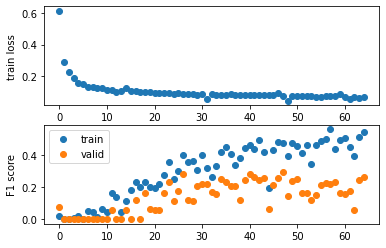

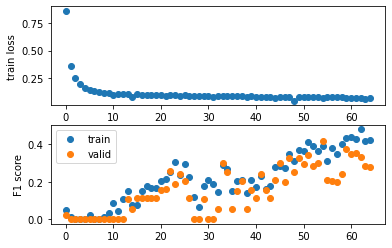

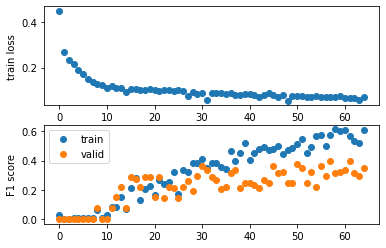

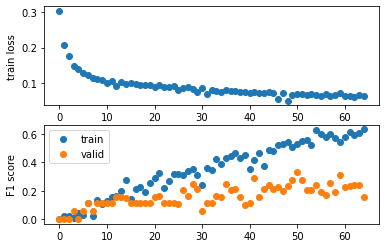

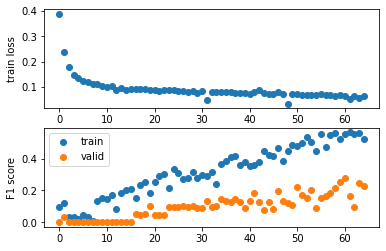

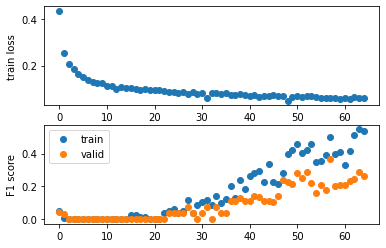

In [32]:
%%capture --no-display
experiment_shorthand(lambda model_dir: dc.models.GraphConvModel(n_tasks=n_tasks, dense_layer_size=10, dropout=.1, model_dir=model_dir), test_dc=test_convmol_ext,
                     experiment_name="gcm_maxmin_6fold_layer10_dropout1_3feat", splits=splits_ext_maxmin_6f_convmol, n_epoch=65, swap_train_val=False)